In [1]:
!pip install fasttext

In [24]:
from huggingface_hub import hf_hub_download
import fasttext
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [3]:
model_path = hf_hub_download(repo_id="facebook/fasttext-en-vectors", filename="model.bin")
en_model = fasttext.load_model(model_path)
model_path_my = hf_hub_download(repo_id="facebook/fasttext-my-vectors", filename="model.bin")
my_model = fasttext.load_model(model_path_my)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [4]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [5]:
import pandas as pd

url_A = "https://github.com/mcfnlp/Dictionary/raw/master/Dictionary(Eng-Myan)Wordlist_Part_A.xls"
url_B = "https://github.com/mcfnlp/Dictionary/raw/master/Dictionary(Eng-Myan)Wordlist_Part_B.xls"

df_A = pd.read_excel(url_A)
df_B = pd.read_excel(url_B)

# Combine them
df = pd.concat([df_A, df_B], ignore_index=True)

print(f"Total rows loaded: {len(df)}")


Total rows loaded: 109638


In [6]:
corpus_eng = df['word'].tolist()
corpus_my = df['def'].tolist()

corpus_eng = [w for w in corpus_eng if isinstance(w, str) and w.strip()]
corpus_my = [w for w in corpus_my if isinstance(w, str) and w.strip()]

print(f"Total word pairs: {len(corpus_my)}")
print("First 5 pairs:")
for i in range(5):
    print(corpus_my[i], "<->", corpus_eng[i])


Total word pairs: 109390
First 5 pairs:
ပထမအင်္ဂလိပ်အက္ခရာ <-> A
မေဂျာ သံစဉ်တွင် ၆ ခုမြောက်အသံ <-> A
ယင်း၏ သံပုံ <-> A
သုံးပေါက်သံ <-> A
ပညာရပ်တစ်ခုခု သင်ယူရာ၌ အမြင့်ဆုံးရနိုင်သော အဆင့် သတ်မှတ်ချက် <-> A


In [9]:
# def words_to_vecs(words, model):
#     vecs = []
#     for w in words:
#         vecs.append(model.get_word_vector(w))
#     return np.stack(vecs)

# def phrases_to_vecs(phrases, model):
#     vecs = []
#     for phrase in phrases:
#         words = phrase.split()
#         word_vecs = [model.get_word_vector(w) for w in words if w in model.get_words()]
#         if word_vecs:
#             vecs.append(np.mean(word_vecs, axis=0))
#         else:
#             vecs.append(np.zeros(model.get_dimension()))
#     return np.stack(vecs)

# english_vecs = words_to_vecs(corpus_eng, en_model)
# burmese_vecs = phrases_to_vecs(corpus_my, my_model)


dim = en_model.get_dimension()

# Function for single words → outputs GPU tensor
def words_to_vecs_gpu(words, model, device=device):
    word_set = set(model.get_words())
    vecs = []
    for w in words:
        if w in word_set:
            vecs.append(torch.tensor(model.get_word_vector(w), device=device))
        else:
            vecs.append(torch.zeros(dim, device=device))
    return torch.stack(vecs)

# Function for phrases → outputs GPU tensor
def phrases_to_vecs_gpu(phrases, model, device=device):
    word_set = set(model.get_words())
    vecs = []
    for phrase in phrases:
        words = phrase.split()
        word_vecs = [torch.tensor(model.get_word_vector(w), device=device) for w in words if w in word_set]
        if word_vecs:
            vecs.append(torch.mean(torch.stack(word_vecs), dim=0))
        else:
            vecs.append(torch.zeros(dim, device=device))
    return torch.stack(vecs)


In [10]:
english_vecs = words_to_vecs_gpu(corpus_eng, en_model)
burmese_vecs = phrases_to_vecs_gpu(corpus_my, my_model)

print("English tensor shape:", english_vecs.shape)
print("Burmese tensor shape:", burmese_vecs.shape)

English tensor shape: torch.Size([109624, 300])
Burmese tensor shape: torch.Size([109390, 300])


In [13]:
burmese_vecs = torch.tensor(burmese_vecs, dtype=torch.float32).to(device)
english_vecs = torch.tensor(english_vecs, dtype=torch.float32).to(device)


/tmp/ipython-input-915777762.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  burmese_vecs = torch.tensor(burmese_vecs, dtype=torch.float32).to(device)
/tmp/ipython-input-915777762.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  english_vecs = torch.tensor(english_vecs, dtype=torch.float32).to(device)


In [14]:
class DAEME(nn.Module):
    def __init__(self, input_dim=300, hidden_dim=300):
        super(DAEME, self).__init__()
        self.encoder_burmese = nn.Linear(input_dim, hidden_dim)
        self.encoder_english = nn.Linear(input_dim, hidden_dim)
        self.decoder_burmese = nn.Linear(hidden_dim, input_dim)
        self.decoder_english = nn.Linear(hidden_dim, input_dim)
        self.activation = nn.ReLU()

        # Weight initialization
        for layer in [self.encoder_burmese, self.encoder_english,
                      self.decoder_burmese, self.decoder_english]:
            nn.init.normal_(layer.weight, mean=0.0, std=0.1)
            nn.init.zeros_(layer.bias)

    def forward(self, burmese_vec, english_vec):
        E1 = self.activation(self.encoder_burmese(burmese_vec))
        E2 = self.activation(self.encoder_english(english_vec))
        meta = torch.cat([E1, E2], dim=1)
        s1_hat = self.decoder_burmese(E1)
        s2_hat = self.decoder_english(E2)
        return meta, (s1_hat, s2_hat)

    @staticmethod
    def apply_masking_noise(batch, noise_fraction=0.2):
        mask = torch.rand_like(batch) > noise_fraction
        return batch * mask.float()


In [19]:
model = DAEME(input_dim=300, hidden_dim=300).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

epochs = 100
batch_size = 20000
num_batches = len(burmese_tensor) // batch_size + 1

for epoch in range(epochs):
    epoch_loss = 0
    for i in range(num_batches):
        start = i * batch_size
        end = min((i+1)*batch_size, len(burmese_tensor))

        burmese_batch = burmese_tensor[start:end]
        english_batch = english_tensor[start:end]

        optimizer.zero_grad()
        burmese_noisy = DAEME.apply_masking_noise(burmese_batch, 0.2)
        english_noisy = DAEME.apply_masking_noise(english_batch, 0.2)

        meta, (b_hat, e_hat) = model(burmese_noisy, english_noisy)
        loss = loss_fn(b_hat, burmese_batch) + loss_fn(e_hat, english_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f"Epoch {epoch}, Avg Loss: {epoch_loss/num_batches:.4f}")


Epoch 0, Avg Loss: 0.0166
Epoch 1, Avg Loss: 0.0154
Epoch 2, Avg Loss: 0.0145
Epoch 3, Avg Loss: 0.0136
Epoch 4, Avg Loss: 0.0129
Epoch 5, Avg Loss: 0.0123
Epoch 6, Avg Loss: 0.0118
Epoch 7, Avg Loss: 0.0114
Epoch 8, Avg Loss: 0.0110
Epoch 9, Avg Loss: 0.0106
Epoch 10, Avg Loss: 0.0103
Epoch 11, Avg Loss: 0.0100
Epoch 12, Avg Loss: 0.0098
Epoch 13, Avg Loss: 0.0095
Epoch 14, Avg Loss: 0.0093
Epoch 15, Avg Loss: 0.0091
Epoch 16, Avg Loss: 0.0089
Epoch 17, Avg Loss: 0.0087
Epoch 18, Avg Loss: 0.0085
Epoch 19, Avg Loss: 0.0083
Epoch 20, Avg Loss: 0.0082
Epoch 21, Avg Loss: 0.0080
Epoch 22, Avg Loss: 0.0079
Epoch 23, Avg Loss: 0.0077
Epoch 24, Avg Loss: 0.0076
Epoch 25, Avg Loss: 0.0075
Epoch 26, Avg Loss: 0.0074
Epoch 27, Avg Loss: 0.0073
Epoch 28, Avg Loss: 0.0071
Epoch 29, Avg Loss: 0.0070
Epoch 30, Avg Loss: 0.0069
Epoch 31, Avg Loss: 0.0068
Epoch 32, Avg Loss: 0.0067
Epoch 33, Avg Loss: 0.0066
Epoch 34, Avg Loss: 0.0066
Epoch 35, Avg Loss: 0.0065
Epoch 36, Avg Loss: 0.0064
Epoch 37, A

In [28]:
mapped_vectors = {}
all_burmese_words = corpus_my
with torch.no_grad():
    for i, w in enumerate(all_burmese_words):
        vec = burmese_vecs[i]                     # Original vector
        mapped_vec = model.encoder_burmese(vec)  # Encode to meta-space
        mapped_vectors[w] = mapped_vec.cpu().numpy()

In [26]:
torch.save(model, "daeme_model.pth")
torch.save(english_vecs, "english_tensor.pt")
torch.save(burmese_vecs, "burmese_tensor.pt")


In [29]:
import pickle

with open("mapped_vectors.pkl", "wb") as f:
    pickle.dump(mapped_vectors, f)


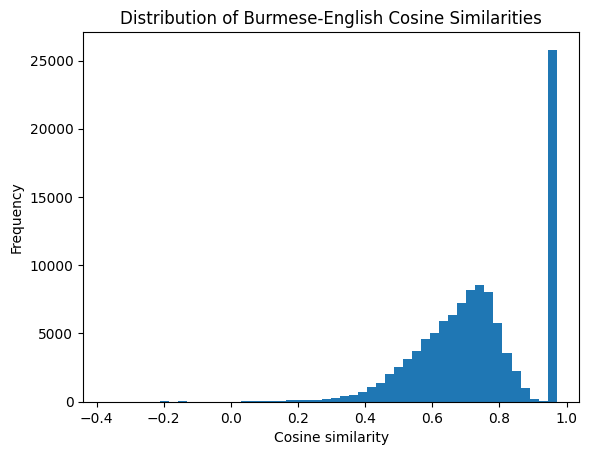

In [31]:
all_sims = []
model.eval()
with torch.no_grad():
    for i in range(len(burmese_tensor)):
        b_vec = model.encoder_burmese(burmese_tensor[i].unsqueeze(0))
        e_vec = model.encoder_english(english_tensor[i].unsqueeze(0))
        sim = F.cosine_similarity(b_vec, e_vec)
        all_sims.append(sim.item())

plt.hist(all_sims, bins=50)
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.title("Distribution of Burmese-English Cosine Similarities")
plt.show()


In [30]:
import pickle

with open("mapped_vectors.pkl", "rb") as f:
    mapped_vectors = pickle.load(f)

print(f"Total mapped vectors: {len(mapped_vectors)}")
example_key = list(mapped_vectors.keys())[0]
print("Example:", example_key, mapped_vectors[example_key][:10])


Total mapped vectors: 76700
Example: ပထမအင်္ဂလိပ်အက္ခရာ [-0.03610078 -0.02706265 -0.02505255 -0.03319115 -0.02951134 -0.02600441
 -0.02033756 -0.039611   -0.03369364 -0.02263284]
